# Lane Finding Software for Self Driving Cars

This notebook describes a first approach to detecting lanes for seld driving cars, using computer vision. 

The process involves 
* ROI
* Edge Detection using Canny Algortihm 
* HoughTransform to detect Lines
* poly-line fitting. 

### Import relevant libraries

In [33]:
# Import relevant libraries 

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import numpy as np 
import cv2 
import os 

from moviepy.editor import VideoFileClip
# Read in a single image frame 


### Create Relevant DataStructures

In [34]:

class PreprocessingData:
    def __init__(self,kernel_size_in):
        self.kernel_size = kernel_size_in
        
class EdgeDetectionData:
    def __init__(self,low_threshold_in,high_threshold_in):
        self.low_threshold = low_threshold_in
        self.high_threshold = high_threshold_in
        
class LineTransformData:
    def __init__(self,rho_in,theta_in,vote_threshold_in,min_line_length_in,max_line_gap_in):
        self.rho = rho_in;
        self.theta = theta_in; 
        self.vote_threshold = vote_threshold_in
        self.min_line_length = min_line_length_in
        self.max_line_gap = max_line_gap_in 
        
class RegionOfInterestData:
    def __init__(self, vertices_in):
        self.roi_vertices = vertices_in 
        

class MaskingData:
    def __init__(self,mask_threshold_in):
        self.mask_threshold = mask_threshold_in

    
        

### Define Helper functions

In [35]:

def preprocessImage(img_frame,preprocess_data_obj):
    """ 
    returns a gray scale image filtered with a gaussian
    Args:
        img_frame : an uint8 image 
        preprocess_obj : an object of class PreprocessingData 
        
    """
    # :: first, convert the image to gray scale 
    imggray = cv2.cvtColor(img_frame, cv2.COLOR_BGR2GRAY)
    img_shape = imggray.shape
    # :: apply a gaussian smoothener to remove noise 
    kernel_size = preprocess_data_obj.kernel_size
    imggray_blur = cv2.GaussianBlur(imggray,(kernel_size,kernel_size),0)
    
    return imggray_blur

def createROIMask(mask_shape,roi_data_obj,masking_data_obj):
    """ returns a mask image where only the pixels within the Region  
        of interest (ROI) is sest to mask_threshold_color
    Args:
        mask_shape : the output shape of the mask. 
        roi_data_obj : an object of class RegionOfInterestData
        masking_data_obj : an object of class MaskingData
    """
    # specify the ROI polygon and set all pixels in that region to 255.
    mask_threshold_color = masking_data_obj.mask_threshold
    roi_vertices = roi_data_obj.roi_vertices
    
    mask = np.zeros(mask_shape).astype(np.uint8)    
    cv2.fillPoly(mask, roi_vertices, mask_threshold_color)
    
    # display the ROI polygon on the original image 
    roi_on_original_image = np.copy(img_frame2)
    cv2.polylines(roi_on_original_image,vertices,True,(255,0,0),2)

    return mask

def detectLaneLines(imggray_blur,roi_data_obj,
                                 edge_detection_data_obj,
                                 masking_data_obj,
                                 line_transform_data_obj):
    """ returns a list of lines that lie on car lanes
    
    """
    low_threshold = edge_detection_data_obj.low_threshold 
    high_threshold = edge_detection_data_obj.high_threshold
    
    min_line_length = line_transform_data_obj.min_line_length
    max_line_gap =  line_transform_data_obj.max_line_gap 
    vote_threshold = line_transform_data_obj.vote_threshold 
    # :: apply canny edge detection to detect edges
    img_shape = imggray_blur.shape
    edges = cv2.Canny(imggray_blur,low_threshold,high_threshold)
    # :: create mask to filter out unwanted edges
    mask = createROIMask(img_shape,roi_data_obj,masking_data_obj)
    masked_edges = np.bitwise_and(edges,mask)
    #:
#     print(" edges size = ",edges.shape)
#     print("mask size = ",mask.shape)
#     print("max edges", edges.max())
#     print(edges.min())
#     print(mask.max())
#     print(mask.min())
#     print("masked_edges shape = ",masked_edges.shape)
#     print("masked_edge type = ",masked_edges.dtype)    
#     print("*"*20)
    #:    
    # perform hough transform to detect lines, and draw the lines 
    lines = cv2.HoughLinesP(masked_edges, rho, theta, vote_threshold,np.array([]),
                            min_line_length, max_line_gap)
    
    lane_lines = [l[0] for l in lines]
    #:: create a 3-channel form of edges
    color_edges = np.dstack((edges,edges,edges))
    # create a color binary image to combine with line_image 
    if DEBUG_ON:
        line_image = annotateImage(np.zeros_like(color_edges), lane_lines,(255,0,0))
        line_edges = cv2.addWeighted(color_edges,0.8,line_image,1,0)
        plt.figure()
        plt.imshow(line_edges)


    return lane_lines, color_edges

def splitLaneLinesIntoRightAndLeft(lane_lines,split_x_position,img_shape):
    """ returns an interpolated set of line segments that cover the entire
        span of points in lines """
    # split the lines into right and left line
    left_lines = []
    right_lines = []

    for line in lane_lines: 
        x1,y1,x2,y2 = line
        if (x1 > img_shape[1]*0.5) and (x2 > split_x_position):
            right_lines.append((x1,y1,x2,y2))
        else:
            left_lines.append((x1,y1,x2,y2))

    #:: reformat left and right lines 
    left_x, left_y  = reformatAsCoordinates(left_lines)
    right_x,right_y = reformatAsCoordinates(right_lines)
    
    return left_x, left_y, right_x, right_y
    
def interpolateLaneLines(lane_lines,split_x_position,base_limit,image_shape):
    #:: split lanes into left and right lanes
    left_x,left_y,right_x,right_y = \
                     splitLaneLinesIntoRightAndLeft(lane_lines,split_x_position,image_shape)
    # extract points for poly fit 
    left_x_min = min(left_x)
    left_x_max = max(left_x)
    right_x_min = min(right_x)
    right_x_max = max(right_x)
    #:: fit a polynomial of deg 2
    left_line_equ = np.poly1d(np.polyfit(left_x,left_y,2))
    right_line_equ = np.poly1d(np.polyfit(right_x,right_y,2))
    #:: using the fit equation, compute the new lane lines 
    new_left_x = np.linspace(left_x_min, left_x_max,10).astype(np.int32)
    new_left_y = left_line_equ(new_left_x).astype(np.int32)

    new_right_x = np.linspace(right_x_min, right_x_max,10).astype(np.int32)
    new_right_y = right_line_equ(new_right_x).astype(np.int32)
    #:: extend the lane lines to the base of the image 
    #new_left_x, new_left_y = extendLaneLines(new_left_x,new_left_y,base_limit)
    #new_right_x,new_right_y = extendLaneLines(new_right_x,new_right_y,base_limit)
    
    #:: reformat as line segments
    left_lines = reformatAsLineSegments(new_left_x,new_left_y)
    right_lines = reformatAsLineSegments(new_right_x,new_right_y)
    #::
    return left_lines + right_lines

def extendLaneLines(lane_x,lane_y, base_limit):
    """ extends the lane lines to meet the base of the image """
    # 
    pass 

def reformatAsCoordinates(lane_lines):
    """ reformats the list of line segments into a two lists of [x], and [y]"""
    lane_x_points, lane_y_points = [],[]

    for line in lane_lines:
        x1,y1,x2,y2 = line
        lane_x_points.append(x1)
        lane_x_points.append(x2)
        lane_y_points.append(y1)
        lane_y_points.append(y2)
        
    return lane_x_points,lane_y_points

def reformatAsLineSegments(lane_x_points,lane_y_points):
    lane_lines = [] 
    for i in range(len(lane_x_points)-1):
        x1,y1 = lane_x_points[i],lane_y_points[i]
        x2,y2 = lane_x_points[i+1],lane_y_points[i+1]
        lane_lines.append((x1,y1,x2,y2))
    return lane_lines


def annotateImage(img,lane_lines,lane_color):
    """ returns a new image, with the lane lines super-imposed on it """
    line_image = np.zeros_like(img)
    for (x1,y1,x2,y2) in lane_lines:
        cv2.line(line_image,(x1,y1),(x2,y2),lane_color,5)
        
    annotated_image = cv2.addWeighted(img,0.8,line_image,1,0)
    return annotated_image
    

def markLanes(image,preprocess_data_obj,
                    roi_data_obj,
                    edge_detection_data_obj,
                    masking_data_obj,
                    line_transform_data_obj,
                    lane_color):
    """ returns an image where the lanes are marked with lane_color """
    #:: preprocess image into a sutable form 
    imggray_blur = preprocessImage(image,preprocess_data_obj)
    print("Showing processed Image")
    print("Blurred image shape = ",imggray_blur.shape)
    plt.imshow(imggray_blur)
    plt.show()
    
    img_shape = imggray_blur.shape 
    #:: detect lane lines  
    lane_lines,color_edges = detectLaneLines(imggray_blur,roi_data_obj,
                                             edge_detection_data_obj,
                                             masking_data_obj,
                                             line_transform_data_obj)
    #:: interpolate lines for better joining
    new_lane_lines = lane_lines
#     interpolateLaneLines(lane_lines,img_shape[1]*0.5,
#                                                       img_shape[0]*0.9,img_shape)
    
    if DEBUG_ON:
        interp_line_edges = annotateImage(color_edges,
                                          new_lane_lines,(255,0,0))
        plt.figure()
        plt.imshow(interp_line_edges)
        plt.title('Interpolated edges ')
    #:: superimpose the detected lane lines on the image
    annotated_image = annotateImage(image,new_lane_lines,lane_color)
    #:: return the annotated image 
    return annotated_image 
    

def getAllImageFilenames(source_directory,extension_tuple = ('.jpg','.png')):
    """
    returns all the filanames that end with any of the extension in extension_tuple
    """
    all_img = [os.path.join(source_directory,filename) 
                      for filename in os.listdir(source_directory)
                       if filename.endswith(extension_tuple)]
    print("Discovered {} files in {}".format(len(all_img),source_directory))
    return all_img



## Display some of the test images 

Discovered 7 files in test_images\


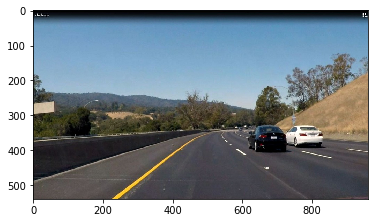

In [36]:
# Load and display the image. 
# Read in a single image frame and convert to gray scale 
test_img_dir = os.path.join('','test_images','')
kTestImagesList  = getAllImageFilenames(test_img_dir)


for i in range(len(kTestImagesList)):
    img_frame2 = mpimg.imread(kTestImagesList[i])
    plt.imshow(img_frame2)
    plt.show()
    break

## Setup The Pipeline

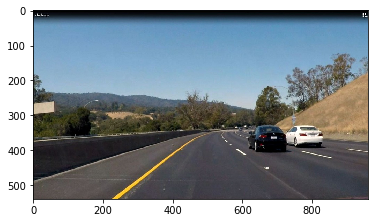

Showing processed Image
Blurred image shape =  (540, 960)


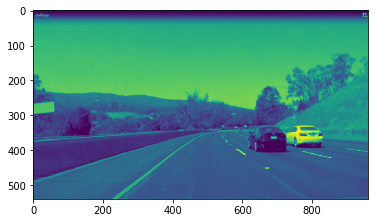

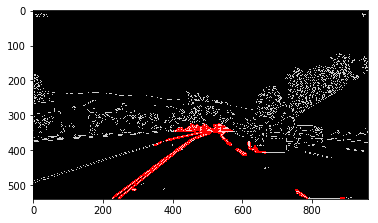

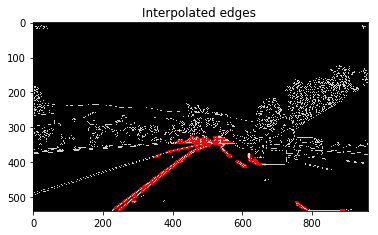

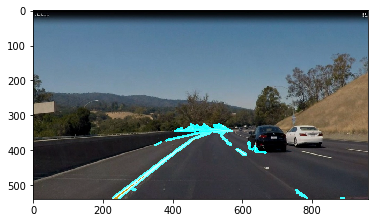

In [40]:
#::specify parameters here  

# kernel size for gaussian blur
kernel_size = 5    
# canny edge detector parameters
low_threshold = 30    
high_threshold = 100  
# hough line transform parameters
rho = 1               #
theta = np.pi / 180 
vote_threshold = 3 
min_line_length = 10 
max_line_gap = 8
#:: 
mask_threshold_color = 255 
#:
p1 = (902,537)
p2 = (533, 326)
p3 = (434, 326)
p4 = (131,537)
roi_vertices = [p1,p2,p3,p4] 
vertices = np.array([roi_vertices])
#::
DEBUG_ON = 1
#=>

#:: Create Relevant Data Objects
preprocess_param = PreprocessingData(kernel_size)
edge_detection_param = EdgeDetectionData(low_threshold,high_threshold)
line_transformation_param = LineTransformData(rho,theta,
                                              vote_threshold,
                                              min_line_length,
                                              max_line_gap)
roi_param = RegionOfInterestData(vertices)
masking_param = MaskingData(mask_threshold_color)

#:: Load an image of the Road
img_frame2 = mpimg.imread(kTestImagesList[0])
plt.imshow(img_frame2)
plt.show()
#:: Perfom LaneDetection 
annotated_img2 = markLanes(img_frame2,preprocess_param,
                                     roi_param,                           
                                     edge_detection_param,
                                     masking_param,
                                     line_transformation_param,
                                     (0,255,255))

#:: Show the results
plt.figure()
plt.imshow(annotated_img2)